In [9]:
#  ----- ALMACEN DE DATOS -----

cache_autores = {}
category = {}
scraped_category = []
books_for_category = []

In [ ]:
#  ----- FUNCIONES GENERALES -----
import requests
import time 




def obtener_autores(titulo):
    if titulo in cache_autores:
        return cache_autores[titulo]
    
    url_api = "https://openlibrary.org/search.json"
    params = {'title' : titulo}

    try:
        respuesta = requests.get(url_api, params=params, timeout=5)
        if respuesta.status_code == 200:
            data = respuesta.json()
            if data.get("numFound",0) > 0:
                autor = data["docs"][0].get("author_name", ["desconocido"])[0]
            else:
                autor = "desconocido"
        else:
            autor = 'error de API'
    except Exception as e:
        autor = "Error"
    
    cache_autores[titulo] = autor
    time.sleep(1)
    return autor




def hacer_requests(url, params=None, max_reintentos=5, tiempo_espera=2):
    for intento in range(1, max_reintentos + 1):
        try:
            respuesta = requests.get(url, params=params, timeout=10)
            
            # si el sitio responde correctamente
            if respuesta.status_code == 200:
                return respuesta

            # si responde con "Too Many Requests"
            elif respuesta.status_code == 429:
                print(f"[!] Límite de peticiones alcanzado. Esperando {tiempo_espera}s...")
                time.sleep(tiempo_espera)
                tiempo_espera *= 2  # aumenta el tiempo de espera progresivamente
            
            else:
                print(f"[!] Error HTTP {respuesta.status_code} en {url}")
                return None

        except (requests.ConnectionError, requests.Timeout):
            print(f"[!] Error de conexión, intento {intento}/{max_reintentos}. Esperando {tiempo_espera}s...")
            time.sleep(tiempo_espera)
            tiempo_espera *= 2

        print(f"[X] No se pudo obtener {url} después de {max_reintentos} intentos.")
        return None




In [ ]:
# ----- Scraper -----

# ----- LIBRERIAS UTILIZADAS ----
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# ---- SCRAPER -----
url = "https://books.toscrape.com"
response = hacer_requests(url)
soup = BeautifulSoup(response.content, 'lxml')

# ----- ACCESO A TODAS LAS CATEGORIAS -----
etiqueta_ul = soup.find('ul', class_='nav nav-list')
etiquetas_list = etiqueta_ul.find_all('li')

for nombre in etiquetas_list:

    categoria = nombre.a.text.strip()
    if categoria in scraped_category or categoria == 'Books':
        continue

    scraped_category.append(categoria)
    print(f"\n [categoria] : {categoria}\n")

    new_url = urljoin(url, nombre.a['href'].strip()) 
    
    while True:
        # ---- COSAS A BUSCAR NECESARIAS -----

        # ---- libros por categoria -----
        respuesta_categoria = hacer_requests(new_url)
        soup_categoria = BeautifulSoup(respuesta_categoria.content, 'lxml')

        etiqueta_div_libros = soup_categoria.find("div", class_="col-sm-8 col-md-9")
        etiqueta_ubicacion_libros = etiqueta_div_libros.find("ol", class_="row")
        etiqueta_libros = etiqueta_ubicacion_libros.find_all('article', class_="product_pod")


        # ---- si tiene etiqueta next la categoria -----
        etiqueta_next = soup_categoria.find("li", class_="next")
        if etiqueta_next:
            link_category = urljoin(new_url, etiqueta_next.a["href"])

        
        # ----- SCRAPER EN SI -----
        for etiqueta_libro in etiqueta_libros:   

            # ----- toda la informacion de los libros -----
            titulo = etiqueta_libro.h3.a['title']
            autor = obtener_autores(titulo)
            
            etiqueta_precio = etiqueta_libro.find("div", class_="product_price")

            precio = etiqueta_precio.find("p", class_="price_color").text
            stock = etiqueta_precio.find("p", class_="instock availability").text.strip()
            estrellas = etiqueta_libro.p["class"][1] 

            books_for_category.append({
                'title' : titulo,
                'author' : autor,
                'category' : categoria,
                'stars' : estrellas,
                'price' : precio,
                'stock' : stock
            })

            print(f"[agregado] : {titulo} : {autor}")

        # ----- si hay otra pagina -----
        if etiqueta_next:
            new_url = link_category
        else:
            break
    

print("[finalizado] todas las categorias se Scrapearon")



In [3]:
# ----- BASE DE DATOS SQLite -----
import sqlite3

# ----- iniciar conexion con base de datos -----
conexion = sqlite3.connect("Books_to_scrape.db")
cursor = conexion.cursor()

# ----- creacion de las tablas -----

cursor.execute("""
CREATE TABLE IF NOT EXISTS Category (
    id_category INTEGER PRIMARY KEY AUTOINCREMENT,
    category_name TEXT UNIQUE
    );
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Author (
    id_author INTEGER PRIMARY KEY AUTOINCREMENT,
    author_name TEXT UNIQUE         
    );
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Book (
    id_book INTEGER PRIMARY KEY AUTOINCREMENT,
    title TEXT UNIQUE NOT NULL,
    price REAL,
    stars INTEGER,
    stock TEXT,
    id_category INTEGER,
    FOREIGN KEY (id_category) REFERENCES Category(id_category)
    );
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS BookAuthor(
    id_author INTEGER,
    id_book INTEGER,
    PRIMARY KEY(id_author, id_book),
    FOREIGN KEY (id_author) REFERENCES Author(id_author)
    FOREIGN KEY (id_book) REFERENCES Book(id_book)
    );
""")

conexion.commit()
conexion.close()

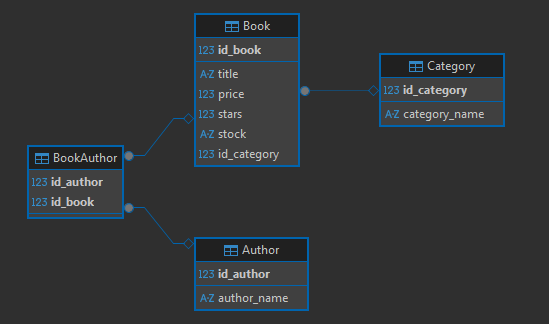

In [ ]:
# ----- INSERCION DE DATOS EN LA BASE DE DATOS -----
import sqlite3
# ---- iniciar conexion -----
conexion = sqlite3.connect("books_to_scrape.db")
cursor = conexion.cursor()

for book in books_for_category:
    categoria_libro = book['category']

    # ----- insertar categorias -----
    cursor.execute("INSERT OR IGNORE INTO Category (category_name) VALUES (?)", (categoria_libro,))
    conexion.commit()

    # ----- recoger la id_category para el libro a insertar -----
    cursor.execute("SELECT id_category FROM Category WHERE category_name = ?", (categoria_libro,))
    id_category = cursor.fetchone()[0]

    # ----- insertar los libros -----
    titulo = book["title"]
    autor = book["author"]
    estrellas = 0
    try:
        estrellas = ["Zero","One","Two","Three","Four","Five"].index(book['stars'].capitalize())
    except ValueError:
        estrellas = None
    precio = float(book['price'].replace('£','').strip()) if '£' in book['price'] else None
    stock = book['stock']

    cursor.execute("INSERT OR IGNORE INTO Author (author_name) VALUES (?)", (autor,))
    conexion.commit()

    cursor.execute("SELECT id_author FROM Author WHERE author_name = ?", (autor,))
    id_author = cursor.fetchone()[0]

    cursor.execute("""INSERT OR IGNORE INTO Book(title, price, stars, stock, id_category) 
                   VALUES (?, ?, ?, ?, ?);""", (titulo, precio, estrellas, stock, id_category))    
    conexion.commit()

    id_book = cursor.lastrowid

    cursor.execute("""INSERT OR IGNORE INTO BookAuthor (id_author, id_book) 
                   VALUES (?, ?)""", (id_author, id_book))
    print(f"[agregado] : {titulo}")

conexion.commit()
conexion.close()

print(f"[fin] insertados todos los datos")



CONSULTAS A LA BASE DE DATOS:

In [ ]:
# ----- CONSULTAS 1 (Listar todos los libros con su categoria y autor) ------
import sqlite3

conexion = sqlite3.connect('Books_to_scrape.db')
cursor = conexion.cursor()

cursor.execute("""
SELECT 
    Book.title AS Libro,
    Category.category_name AS Categoria,
    Author.author_name AS Autor
FROM
    Book
JOIN Category ON Category.id_category = Book.id_category
JOIN BookAuthor ON BookAuthor.id_book = Book.id_book
JOIN Author ON Author.id_author = BookAuthor.id_author;
""")

consulta = cursor.fetchall()

for fila in consulta:
    print(fila)

conexion.close()

In [ ]:
# ----- CONSULTA 2 (mostrar libros sin autores definidos) -----
import sqlite3

conexion = sqlite3.connect('Books_to_scrape.db')
cursor = conexion.cursor()

cursor.execute("""
SELECT
    Book.title AS libro,
    Author.author_name AS Confirmacion_Autor
FROM 
    Book
JOIN BookAuthor ON BookAuthor.id_book = Book.id_book
JOIN Author ON Author.id_author = BookAuthor.id_author
WHERE Confirmacion_Autor = 'desconocido'
GROUP BY Book.title;
""")

consulta = cursor.fetchall()

for fila in consulta:
    print(fila)

conexion.close()


In [ ]:
# ----- CONSULTA 3 (Libros con rating mayor a X) -----
import sqlite3

conexion = sqlite3.connect('Books_to_scrape.db')
cursor = conexion.cursor()

cursor.execute("""
SELECT 
    Book.title AS libro,
    Book.stars AS rating
FROM 
    Book 
WHERE Book.stars > 3;
""")

consulta = cursor.fetchall()

for fila in consulta:
    print(fila)

conexion.close()


In [ ]:
# ----- CONSULTA 4 (mostrar los libros que tienen mas autores que el promedio de libros) -----
import sqlite3

conexion = sqlite3.connect('Books_to_scrape.db')
cursor = conexion.cursor()

cursor.execute("""
SELECT 
    Book.title AS libro,
    COUNT(BookAuthor.id_author) AS TotalAutores
FROM 
    Book
    JOIN BookAuthor ON BookAuthor.id_book = Book.id_book
GROUP BY 
    Book.id_book
HAVING 
    COUNT(BookAuthor.id_author) > (
        SELECT 
            AVG(cantidad_autores)
        FROM (
            SELECT
                COUNT(BookAuthor.id_author) AS cantidad_autores
            FROM
                BookAuthor
            GROUP BY
                BookAuthor.id_book
        )
    );
""")

consulta = cursor.fetchall()

for fila in consulta:
    print(fila)

conexion.close()


('Searching for Meaning in Gailana', 2)


In [ ]:
# ----- CONSULTA 5 (mostrar libros con stock disponible) -----
import sqlite3

conexion = sqlite3.connect('Books_to_scrape.db')
cursor = conexion.cursor()

cursor.execute("""
SELECT 
    Book.title AS libro,
    Book.stock AS confirmation
FROM 
    Book 
WHERE
    Book.stock LIKE '%In stock%';
""")

consulta = cursor.fetchall()

for fila in consulta:
    print(fila)

conexion.close()
